# The H1N1 pandemin in Sweden 2009

### Import and miscellaneous

In [360]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

In [361]:
S = 'susceptible'
I = 'infected'
R = 'recovered'
V = 'vaccinated'

### Functions

In [362]:
def set_initial_states(G, n_infected, vac=None):
    init_infected = np.random.choice(list(G.nodes), n_infected, replace=False)
    for n in G.nodes:
        if n not in init_infected:
            G.nodes[n]['state'] = S
        else:
            G.nodes[n]['state'] = I
    if vac != None:
        init_vac = np.random.choice([G.nodes[n]['state'] == S for n in G.nodes], vac, replace=False)
        for n in init_vac:
            G.nodes[n]['state'] = V
        
    return init_infected
    

In [363]:
def count_infected_neighbor(G, node):
    return sum([G.nodes[n]['state'] == I for n in G[node]])

In [364]:
def update_graph(G, state):
    for n in state.keys():
        G.nodes[n]['state'] = state[n]

In [365]:
def simulation_one_week(G, beta, rho, stat):
    adj = {}
    new_infected = 0
    for n in G.nodes:
        m = count_infected_neighbor(G,n)
        if G.nodes[n]['state'] == S:
            if np.random.random() < 1 - (1 - beta)**m:
                adj[n] = I
                #print(f"Node {n} will be in state I\nActual state: {G.nodes[n]['state']} ")
                #save_N = n
                #G.nodes[n]['state'] = I
                new_infected +=1
                stat[1] += 1
                stat[0] -= 1
        elif G.nodes[n]['state'] == I:
            if np.random.random() < rho:
                adj[n] = R
                #G.nodes[n]['state'] = R
                stat[2] +=1
                stat[1] -= 1
    update_graph(G, adj)
    #print(f"Node {save_N} now is {G.nodes[save_N]['state']}")


    return stat, new_infected

In [366]:
def noVax(G):
    v = [n for n in G.nodes if G.nodes[n]['state'] != V]
    return v

In [367]:
def vaccination(G, n_to_be_vacc, no_Vax, stat):
    newvax = np.random.choice(no_Vax, n_to_be_vacc, replace = False)
    for n in newvax:
        no_Vax.remove(n)
        if G.nodes[n]['state'] == S:
            stat[0] -= 1
            stat[-1] +=1
            G.nodes[n]['state'] = V
        elif G.nodes[n]['state'] == I:
            stat[1] -= 1
            stat[-1] +=1
            G.nodes[n]['state'] = V
        elif G.nodes[n]['state'] == R:
            stat[2] -= 1
            stat[-1] +=1
            G.nodes[n]['state'] = V
    return stat, len(newvax)

In [368]:
def simulation(G, beta, rho, init_infected, niter, vac=[]):
    if not vac:  #no vaccination
        vac = [0] * niter
    n = len(G)
    no_Vax = list(range(n))
    #v = 0 #number of people vaccinated
    n_weekly_vacc = [((x)*n)//100 for x in vac]
    #print(n_weekly_vacc)
    v = n_weekly_vacc[0]
    vac_per_week = [v]
    #n_to_be_vacc = [((y-x)*n)//100 for x, y in zip(vac, vac[1:])] #number of vaccination during week
    #n_to_be_vacc.extend([n_to_be_vacc[-1]]*(niter-len(n_to_be_vacc)))
    #n_weekly_vacc.extend([n_weekly_vacc[-1]]*(niter-len(n_weekly_vacc)))
    infected = [init_infected]
    set_initial_states(G, init_infected, v)
    stat = [[len(G.nodes)-init_infected-v, init_infected, 0, v]] #[#S, #I, #R, #V]
    #print(stat)
    for i in range(1,niter):
        new_stat, v_new = vaccination(G, n_weekly_vacc[i]-v, no_Vax,  stat[-1].copy())
        v += v_new
        vac_per_week.append(v_new)
        #print(new_stat)
        stat_weekly, new_inf = simulation_one_week(G, beta, rho, new_stat.copy())
        infected.append(new_inf)
        stat.append(stat_weekly)
    return stat, infected, vac_per_week

In [369]:
def k_regular(n, k): # k is assumed to be even
    G = nx.Graph()
    # add edges between a node and the following (modular) k/2 nodes
    G.add_edges_from([(i,(j%n)+1) for i in range(1,n+1) for j in range(i, i+(k//2))])
    return G

In [370]:
def preferential_attachment_random_graph(n, k):
    G = nx.complete_graph(k+1)
    degrees = [k]*(k+1)
    c = k//2
    for i in range(k+1,n):
        c += int(k%2 == 1 and i%2 == 1) 
        for x in np.random.choice(i, c, replace=False, p=np.array(degrees)/np.array(degrees).sum()):
            G.add_edge(i, x)
            degrees[x] += 1
        degrees.append(c)
    return G

In [434]:
def configuration_model(n, k):
    """
    Creates and returns a Configuration model graph with a ring topology,
    given the number of nodes n, the number of nearest neighbors k.
    
    Parameters:
    n (int): number of nodes
    k (int): number of nearest neighbors
    
    Returns:
    G (networkx.Graph): Configuration model graph
    """
    degree_sequence = [k]*n
    G = nx.configuration_model(degree_sequence)
    G = nx.Graph(G) # remove parallel edges and self-loops
    return G

In [435]:
def small_world(n, k, p=0.05, to_print=False):
    """
    Creates and returns a Newman-Watts-Strogatz small-world graph,
    given the number of nodes n, the number of nearest neighbors k, 
    and the probability of rewiring p.
    
    Parameters:
    n (int): number of nodes
    k (int): number of nearest neighbors
    p (float): probability of rewiring (default=0.05)
    
    Returns:
    G (networkx.Graph): Newman-Watts-Strogatz small-world graph
    """
    G = nx.newman_watts_strogatz_graph(n, k, p)
    average_degree=sum([d for n,d in G.degree()])/G.number_of_nodes()
    if to_print==True:
        print("Average degree: ", average_degree)
        print("Diameter:", nx.diameter(G))
        print("Clustering coefficient", nx.average_clustering(G), "\n")
        pos = nx.circular_layout(G)
    return G

## Simulations pandemic

***Simulation regular graph (1.1)***


In [371]:
beta = 0.3
rho = 0.7
n_infected = 10
n_weeks = 15

In [372]:
stat_i = []
weekly_inf = []
for _ in range(100):
    G = k_regular(500, 4)
    stat, new_inf, _ = simulation(G, beta, rho, n_infected, n_weeks)
    stat_i.append(stat)
    weekly_inf.append(new_inf)


In [373]:
avg = np.mean(weekly_inf, axis=0)

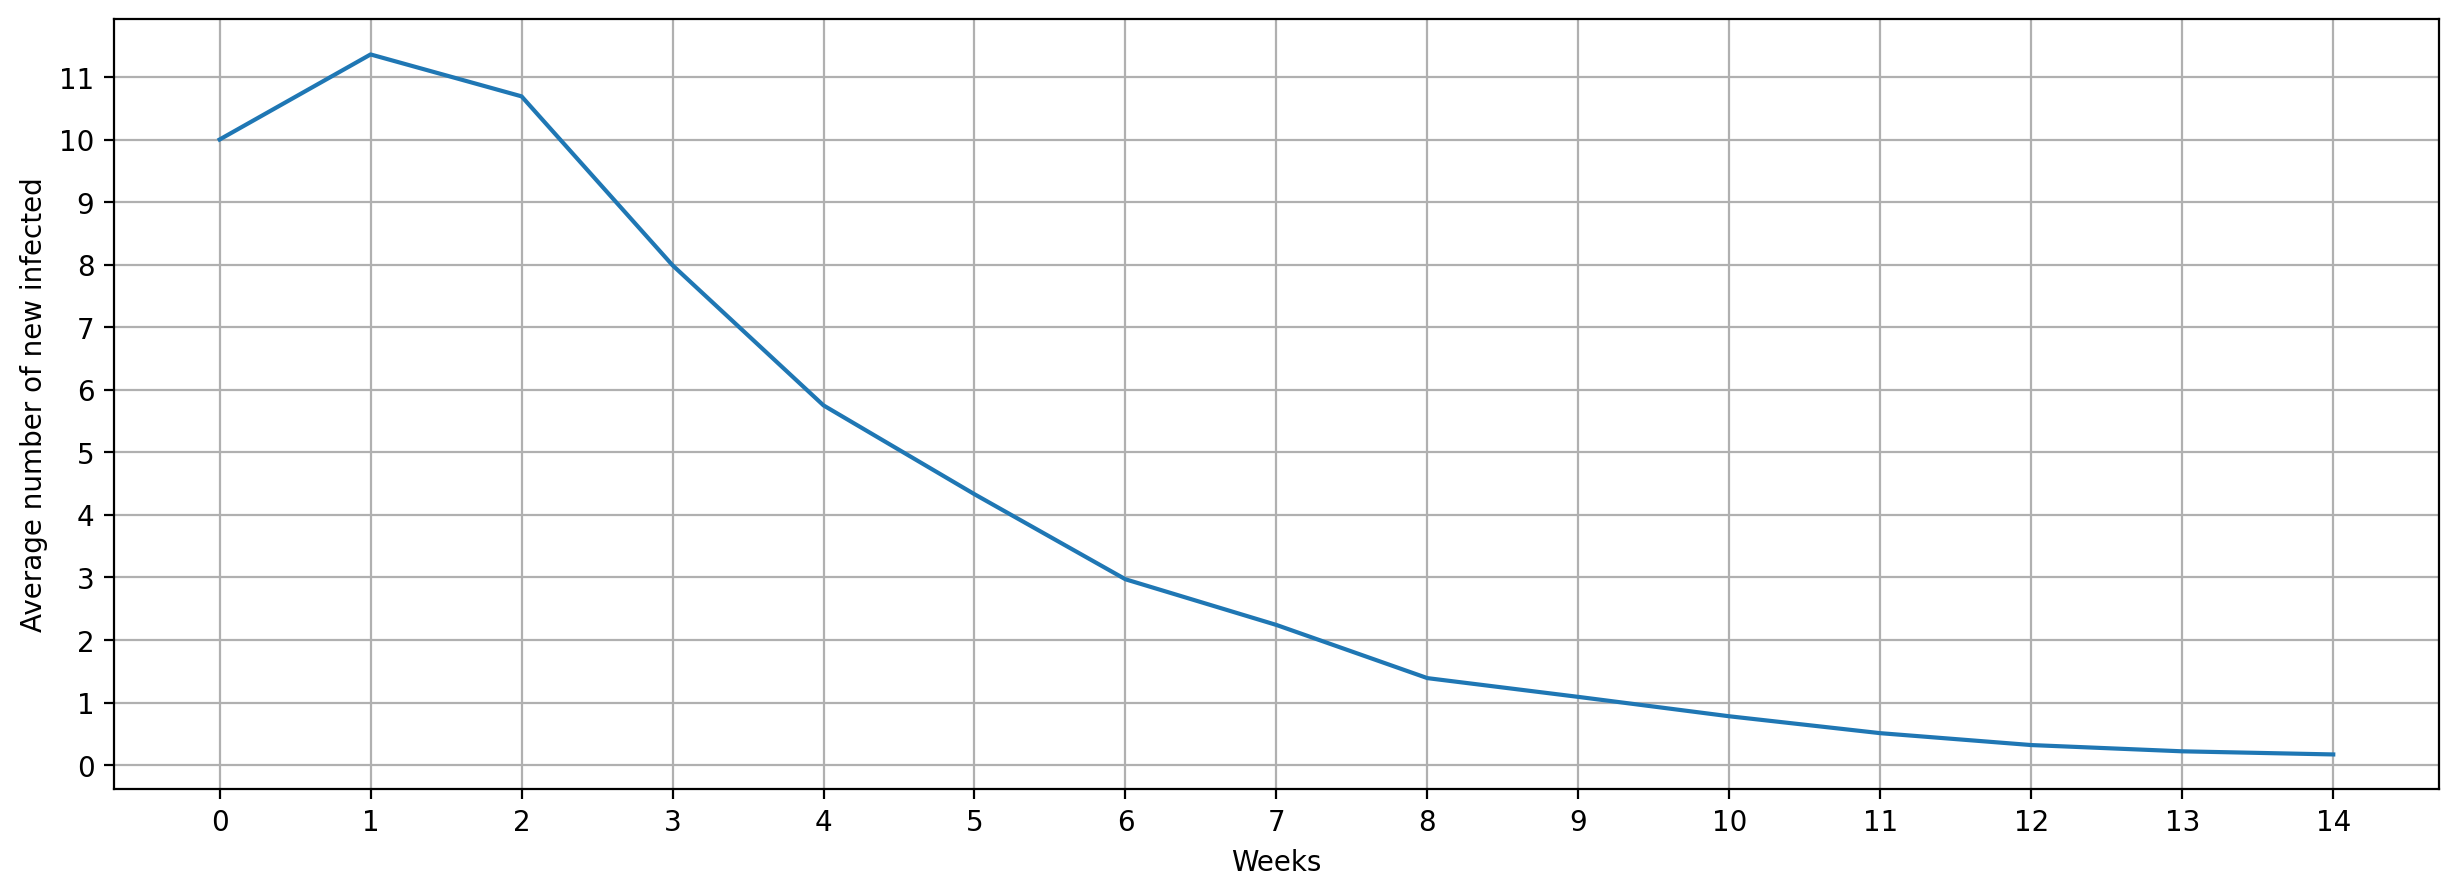

In [374]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(data=list(avg))
setx = f.set_xticks(range(len(avg)))
sety = f.set_yticks(range(round(np.max(avg))+1))
setxlab = f.set_xlabel('Weeks')
setylab = f.set_ylabel('Average number of new infected')
plt.savefig('img/avg_inf_known_graph.png')

In [375]:
susc = np.mean(stat_i, axis=0)[:,0]
inf = np.mean(stat_i, axis=0)[:,1]
rec = np.mean(stat_i, axis=0)[:,2]

In [376]:
np.mean(stat_i, axis=0)

array([[4.9000e+02, 1.0000e+01, 0.0000e+00, 0.0000e+00],
       [4.7864e+02, 1.4590e+01, 6.7700e+00, 0.0000e+00],
       [4.6795e+02, 1.4970e+01, 1.7080e+01, 0.0000e+00],
       [4.5996e+02, 1.2420e+01, 2.7620e+01, 0.0000e+00],
       [4.5421e+02, 9.4900e+00, 3.6300e+01, 0.0000e+00],
       [4.4988e+02, 7.0800e+00, 4.3040e+01, 0.0000e+00],
       [4.4691e+02, 4.9000e+00, 4.8190e+01, 0.0000e+00],
       [4.4467e+02, 3.6700e+00, 5.1660e+01, 0.0000e+00],
       [4.4328e+02, 2.5800e+00, 5.4140e+01, 0.0000e+00],
       [4.4219e+02, 1.8200e+00, 5.5990e+01, 0.0000e+00],
       [4.4141e+02, 1.3100e+00, 5.7280e+01, 0.0000e+00],
       [4.4090e+02, 9.5000e-01, 5.8150e+01, 0.0000e+00],
       [4.4058e+02, 5.7000e-01, 5.8850e+01, 0.0000e+00],
       [4.4036e+02, 3.5000e-01, 5.9290e+01, 0.0000e+00],
       [4.4019e+02, 2.9000e-01, 5.9520e+01, 0.0000e+00]])

In [377]:
sta_avg = np.mean(stat_i, axis=0)

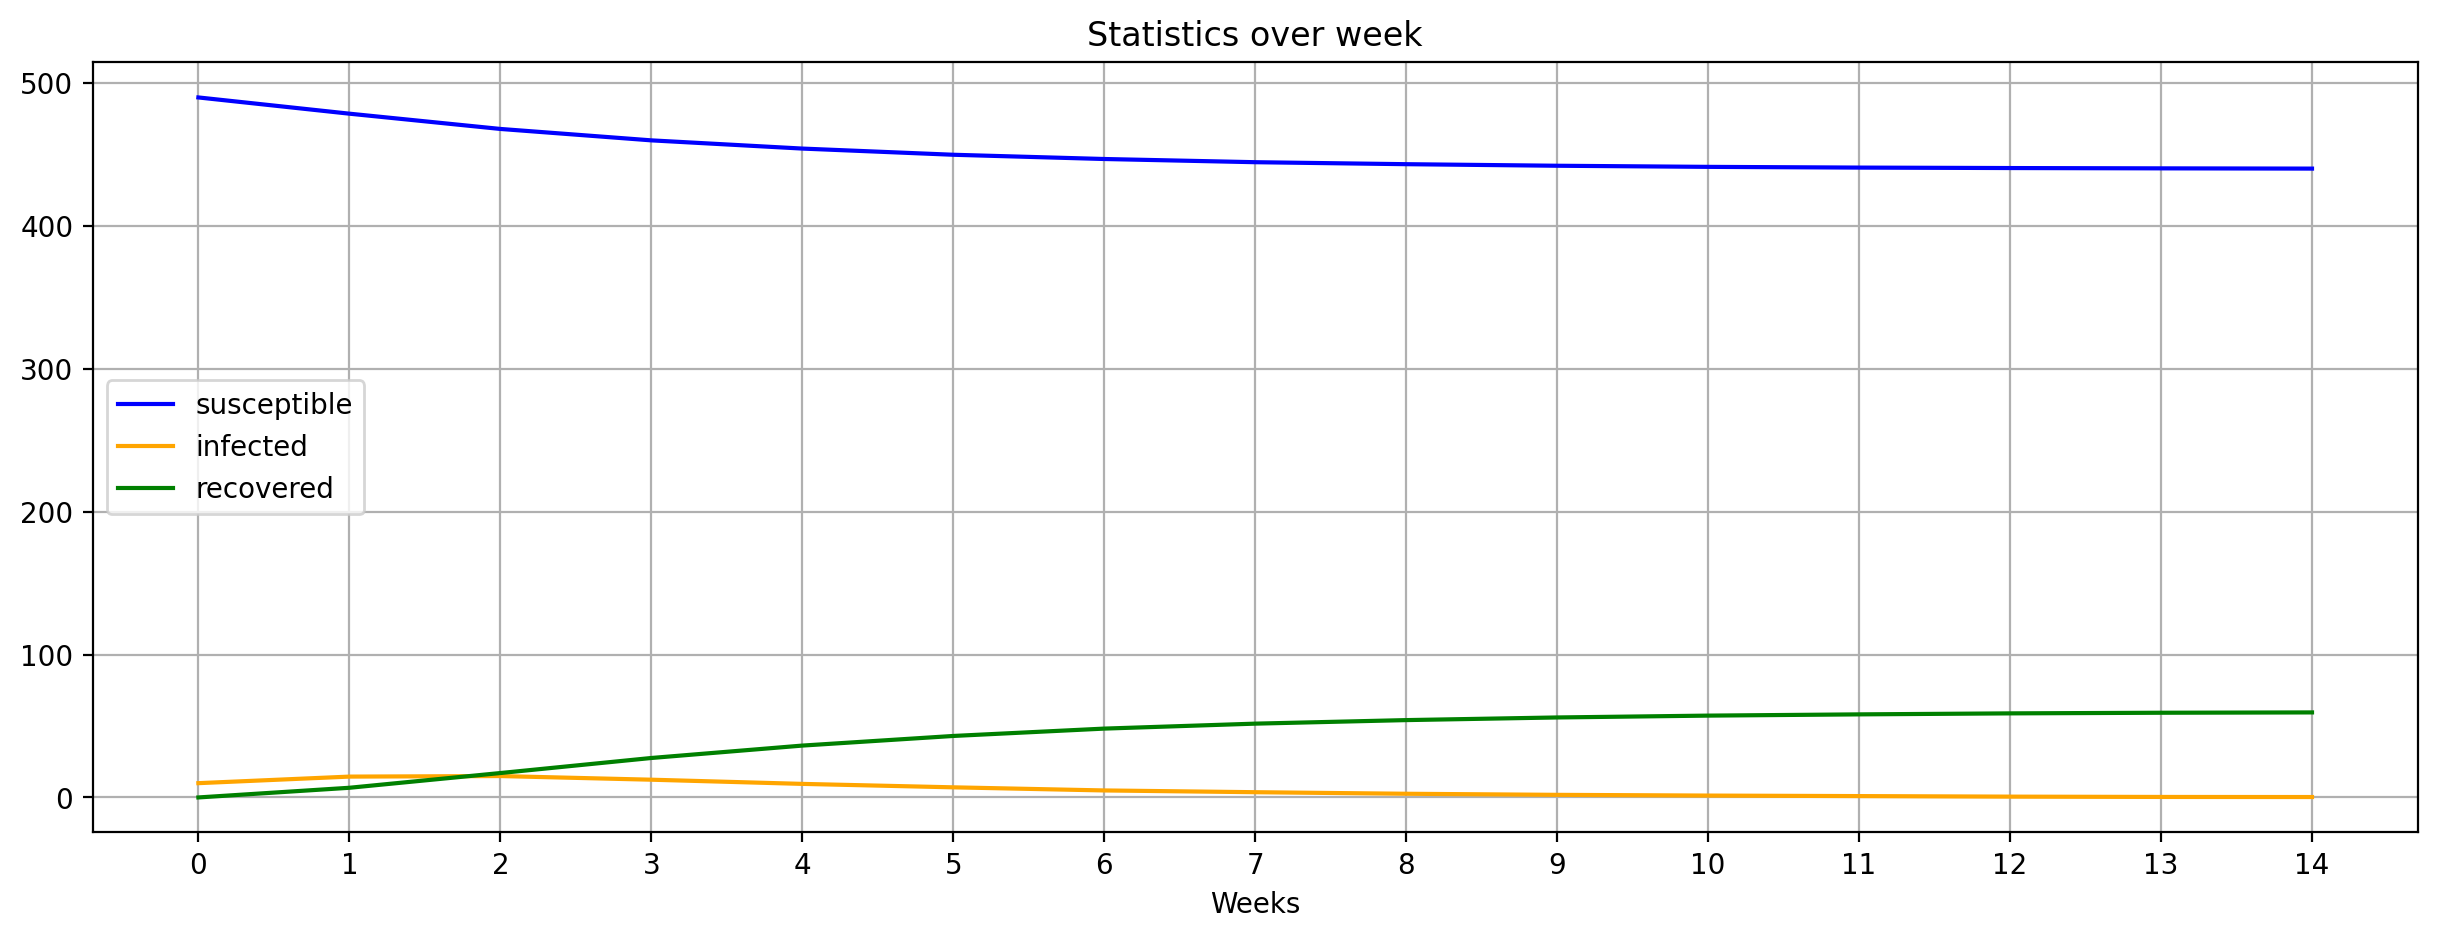

In [378]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
fs = sn.lineplot(data=list(susc), color='blue', label=S)
fi = sn.lineplot(data=list(inf), color='orange', label=I)
fr = sn.lineplot(data=list(rec), color='green', label=R)
setx = fs.set_xticks(range(len(avg)))
sety = f.set_yticks(range(round(np.max(avg))+1))
setxlab = fs.set_xlabel('Weeks')
cap = fs.set_title('Statistics over week')
plt.legend(loc='center left')
plt.savefig('img/SIR_known_graph.png')

In [379]:
np.mean(weekly_inf, axis=0)

array([10.  , 11.36, 10.69,  7.99,  5.75,  4.33,  2.97,  2.24,  1.39,
        1.09,  0.78,  0.51,  0.32,  0.22,  0.17])

## Simulations pandemic with preferential attachment model

***Simulation preferential attachment random graph without vaccination (1.2)***

In [380]:
# G2 = nx.random_regular_graph(3,8)
# G2.nodes[1]['state'] = 's'
# G2.nodes[1]
# G2.nodes
# adj = [(0, {'state':'s'})]
# adj.append((2, {'state':'r'}))
# G2.update(nodes=adj)
# G2.nodes[2]

In [381]:
G2 = preferential_attachment_random_graph(500,6)

In [382]:
stat_i2 = []
weekly_inf2 = []
for _ in range(100):
    G2 = preferential_attachment_random_graph(500,6)
    stat, new_inf, _ = simulation(G2, beta, rho, n_infected, n_weeks)
    stat_i2.append(stat)
    weekly_inf2.append(new_inf)

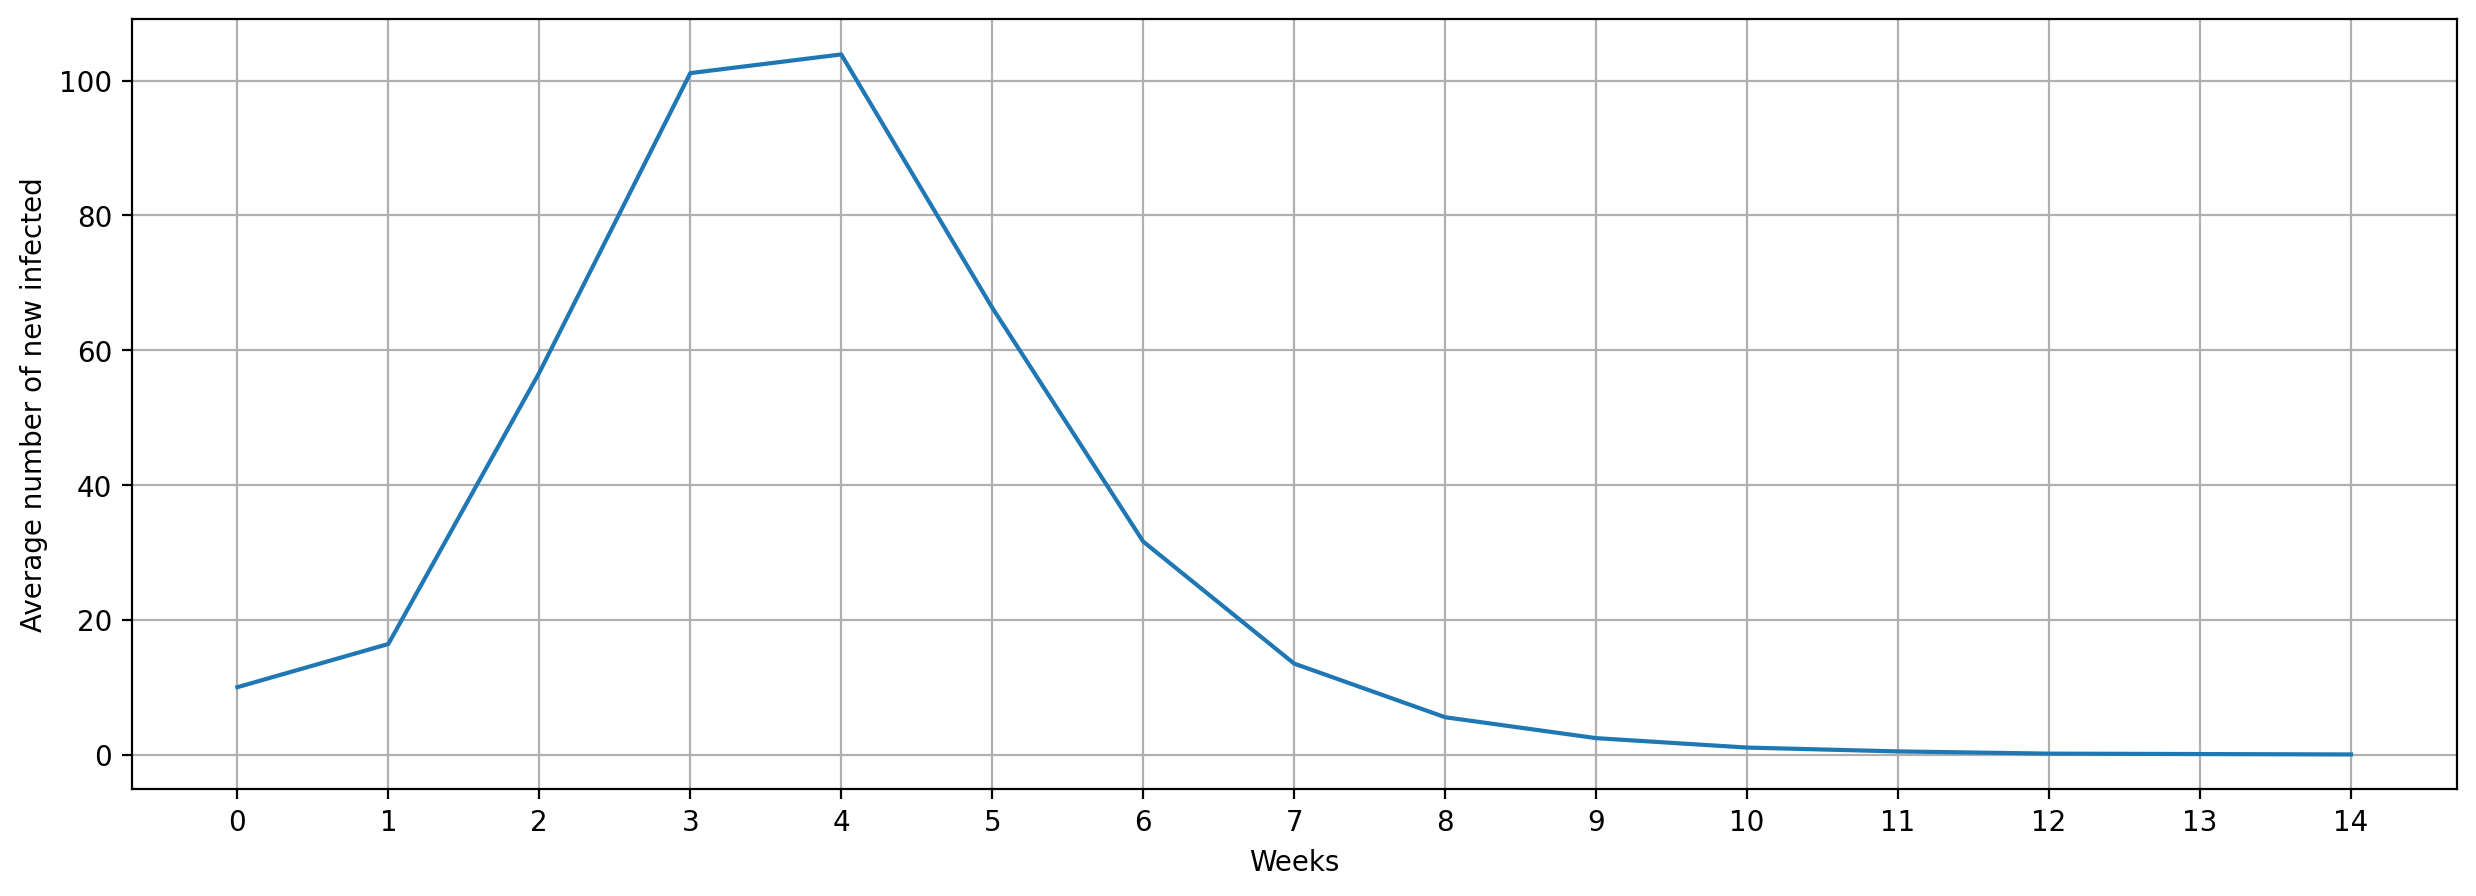

In [383]:
avg2 = np.mean(weekly_inf2, axis=0)
plt.figure(dpi = 200, figsize=(15,5))
f = sn.lineplot(data=list(avg2))
setx = f.set_xticks(range(len(avg2)))
#sety = f.set_yticks(range(round(np.max(avg2))+1))
f.set_xlabel('Weeks')
f.set_ylabel('Average number of new infected')
plt.grid()
plt.savefig('img/avg_preferentialNOVAX.png')

In [384]:
avgstat = np.mean(stat_i2, axis=0)

In [385]:
susc = np.mean(stat_i2, axis=0)[:,0]
inf = np.mean(stat_i2, axis=0)[:,1]
rec = np.mean(stat_i2, axis=0)[:,2]

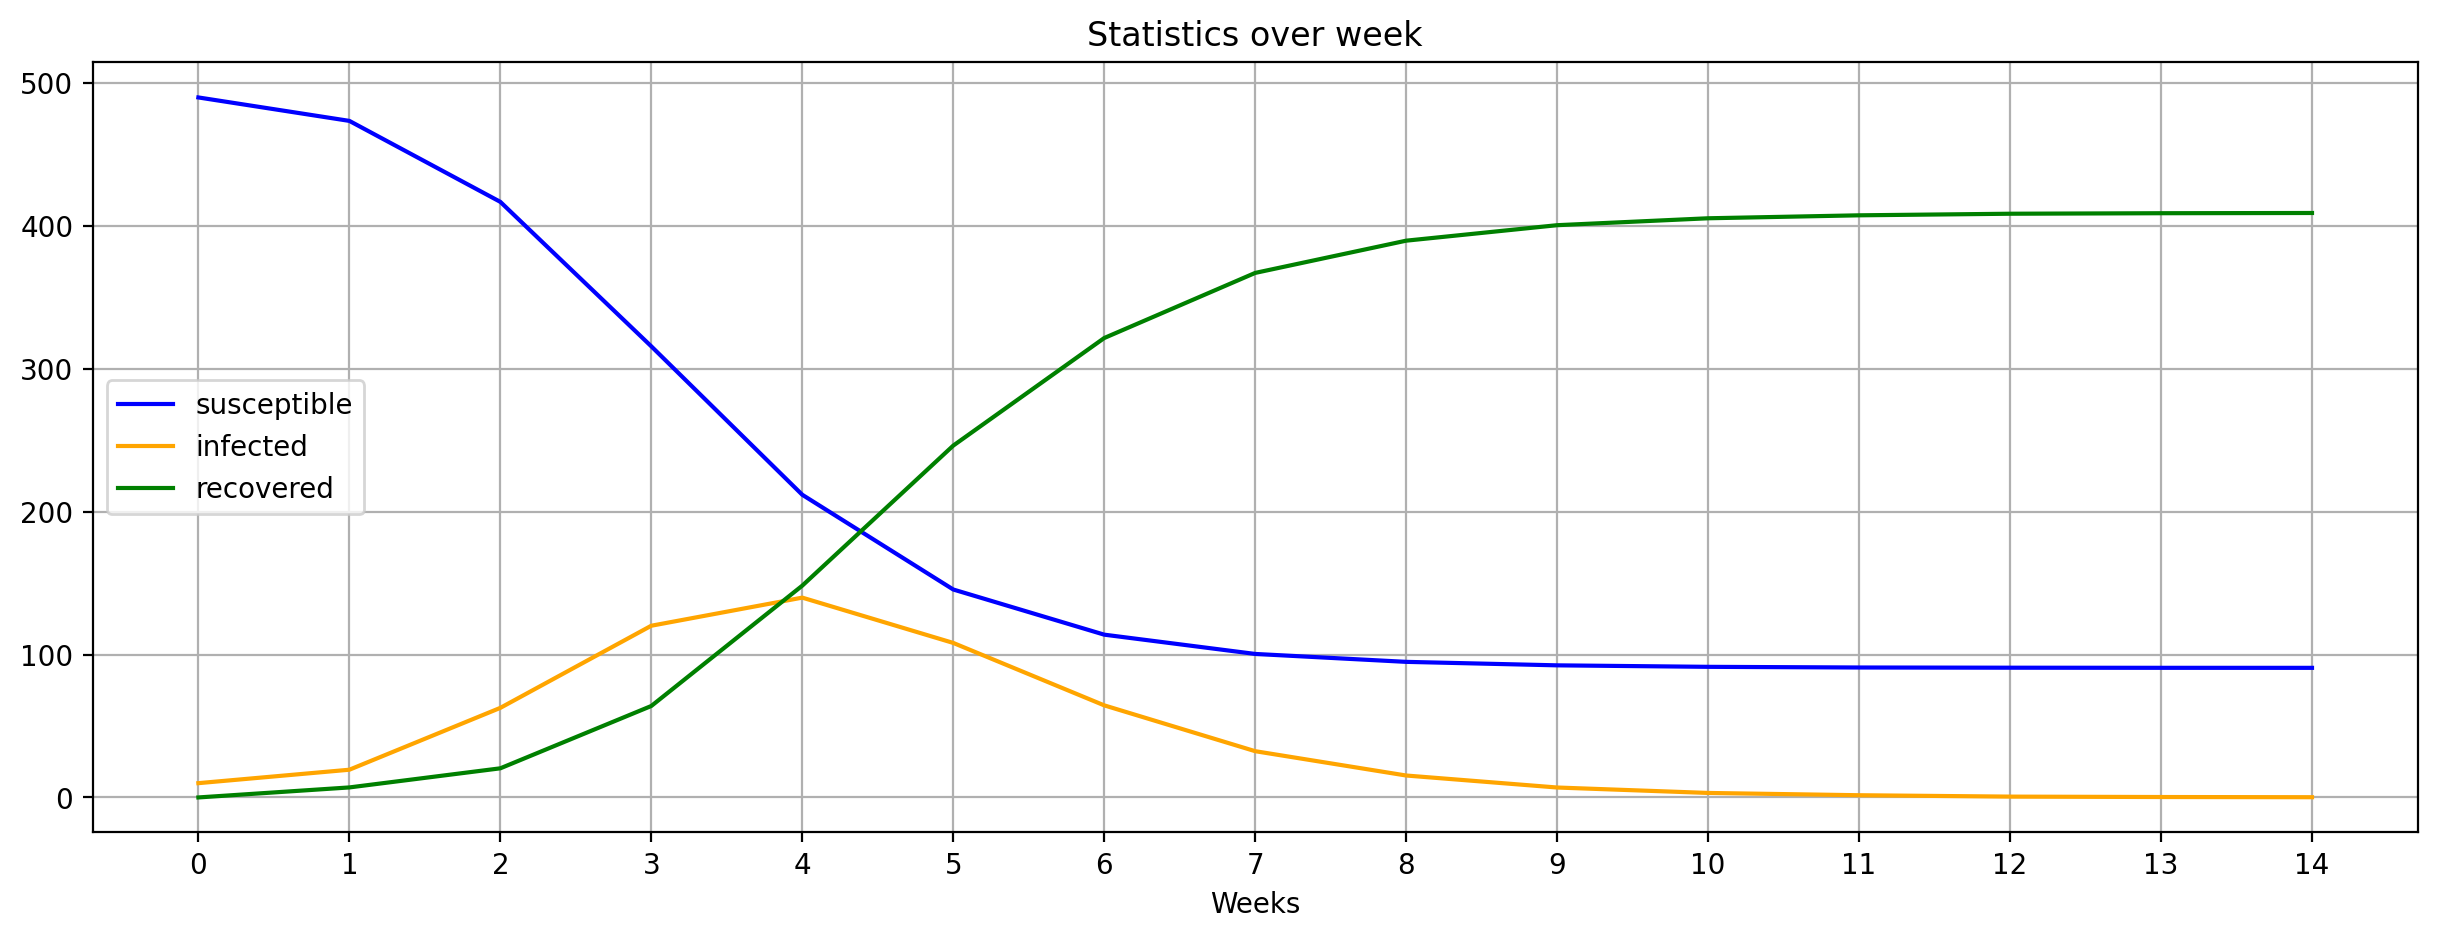

In [386]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
fs = sn.lineplot(data=list(susc), color='blue', label=S)
fi = sn.lineplot(data=list(inf), color='orange', label=I)
fr = sn.lineplot(data=list(rec), color='green', label=R)
setx = fs.set_xticks(range(len(avg)))
sety = f.set_yticks(range(round(np.max(avg))+1))
setxlab = fs.set_xlabel('Weeks')
cap = fs.set_title('Statistics over week')
plt.legend(loc='center left')
plt.savefig('img/SIR_NOVAX.png')

## Simulations pandemic with vaccination

***Vaccination (1.3)***

In [387]:
vac =  [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

In [388]:
stat_i3 = []
weekly_inf3 = []

for _ in range(100):
    G = preferential_attachment_random_graph(500, 6)
    stat, inf, vaccinated = simulation(G, beta, rho, n_infected, n_weeks, vac)

    stat_i3.append(stat)
    weekly_inf3.append(inf)

<Figure size 1280x960 with 0 Axes>

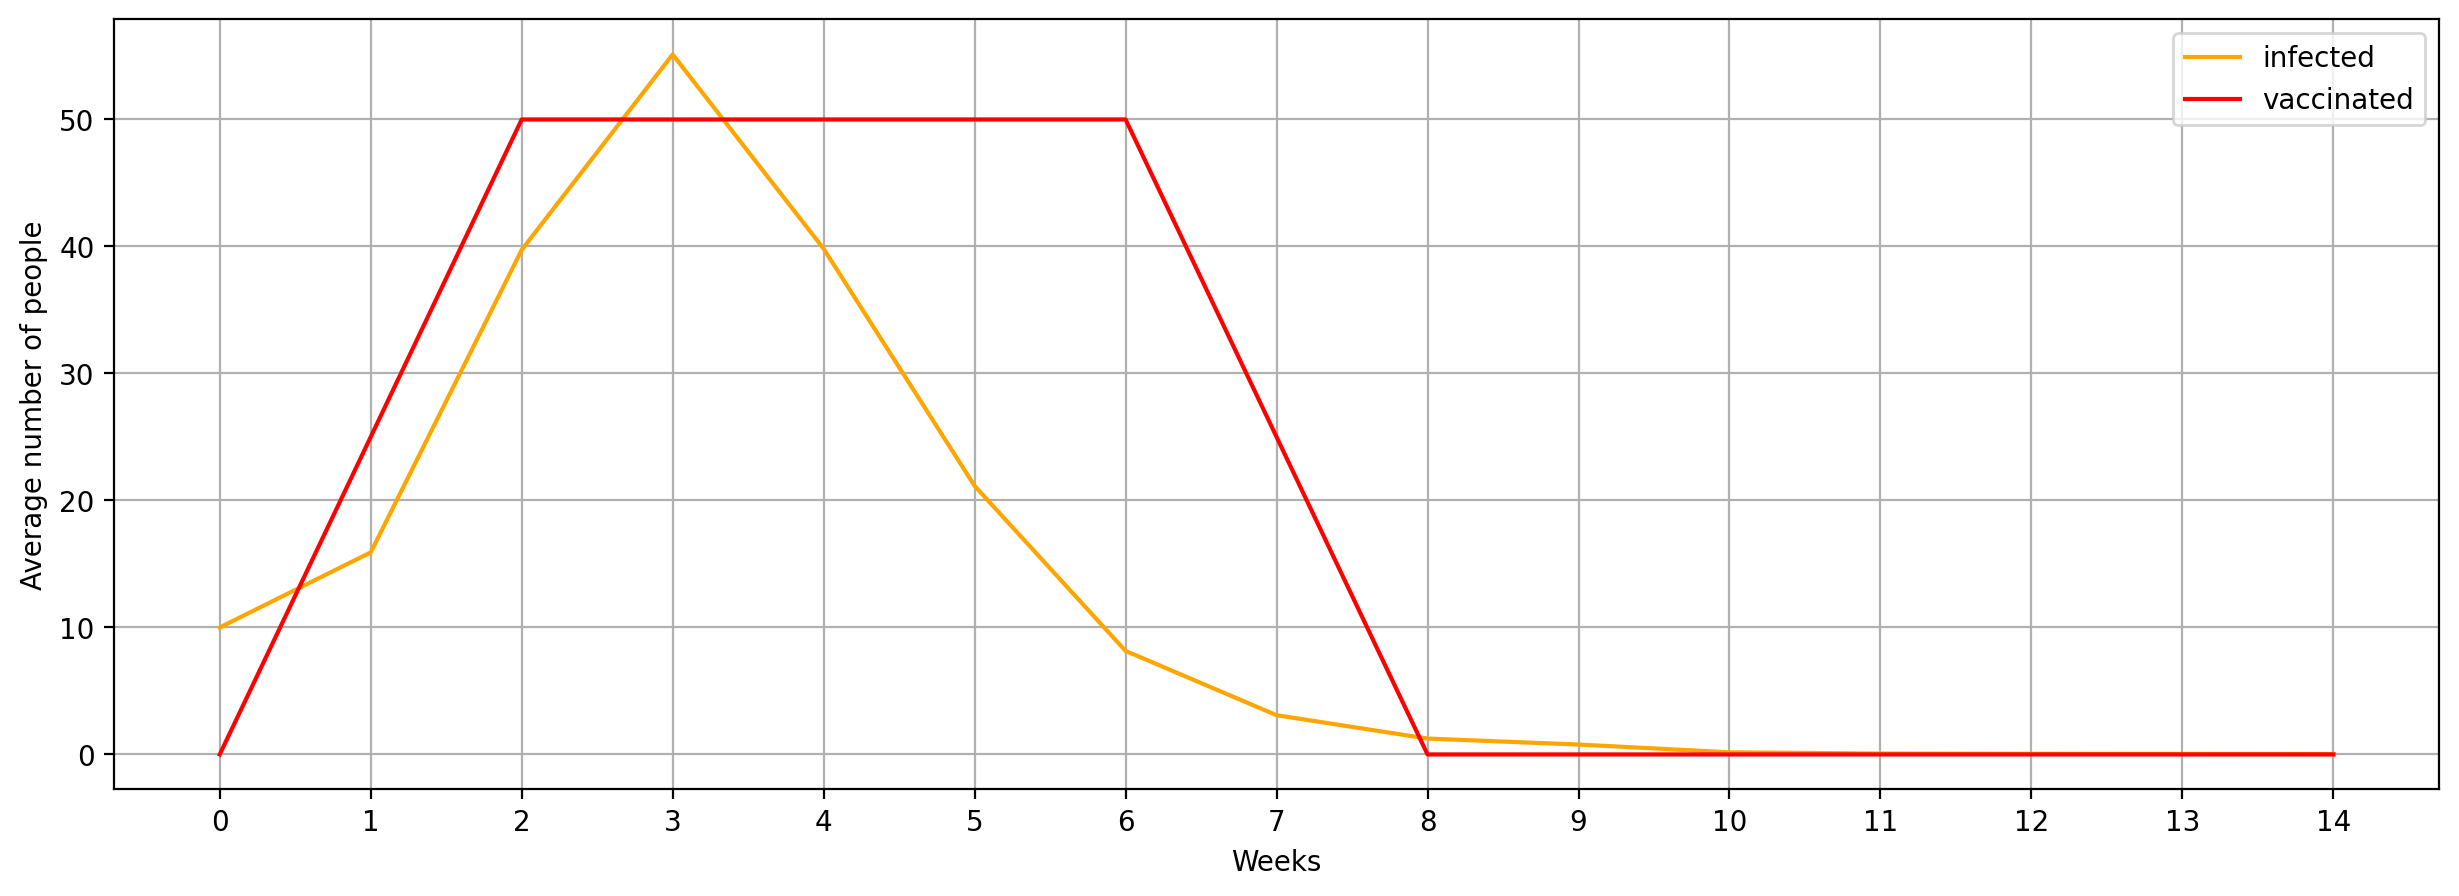

In [389]:
stat_i3 = np.array(stat_i3)
avg3_stat = np.mean(stat_i3, axis=1)
avg3 = np.mean(weekly_inf3, axis=0)
plt.figure(dpi=200)
plt.figure(dpi=200, figsize=(15,5))
plt.grid()
f = sn.lineplot(data=list(avg3), label=I, color='orange')
fv = sn.lineplot(data=list(vaccinated), label=V, color='red')
setx = f.set_xticks(range(len(avg)))
f.set_xlabel('Weeks')
f.set_ylabel('Average number of people')
plt.legend(loc='upper right')
plt.savefig('img/avg_newinf_newvac.png')
plt.show()

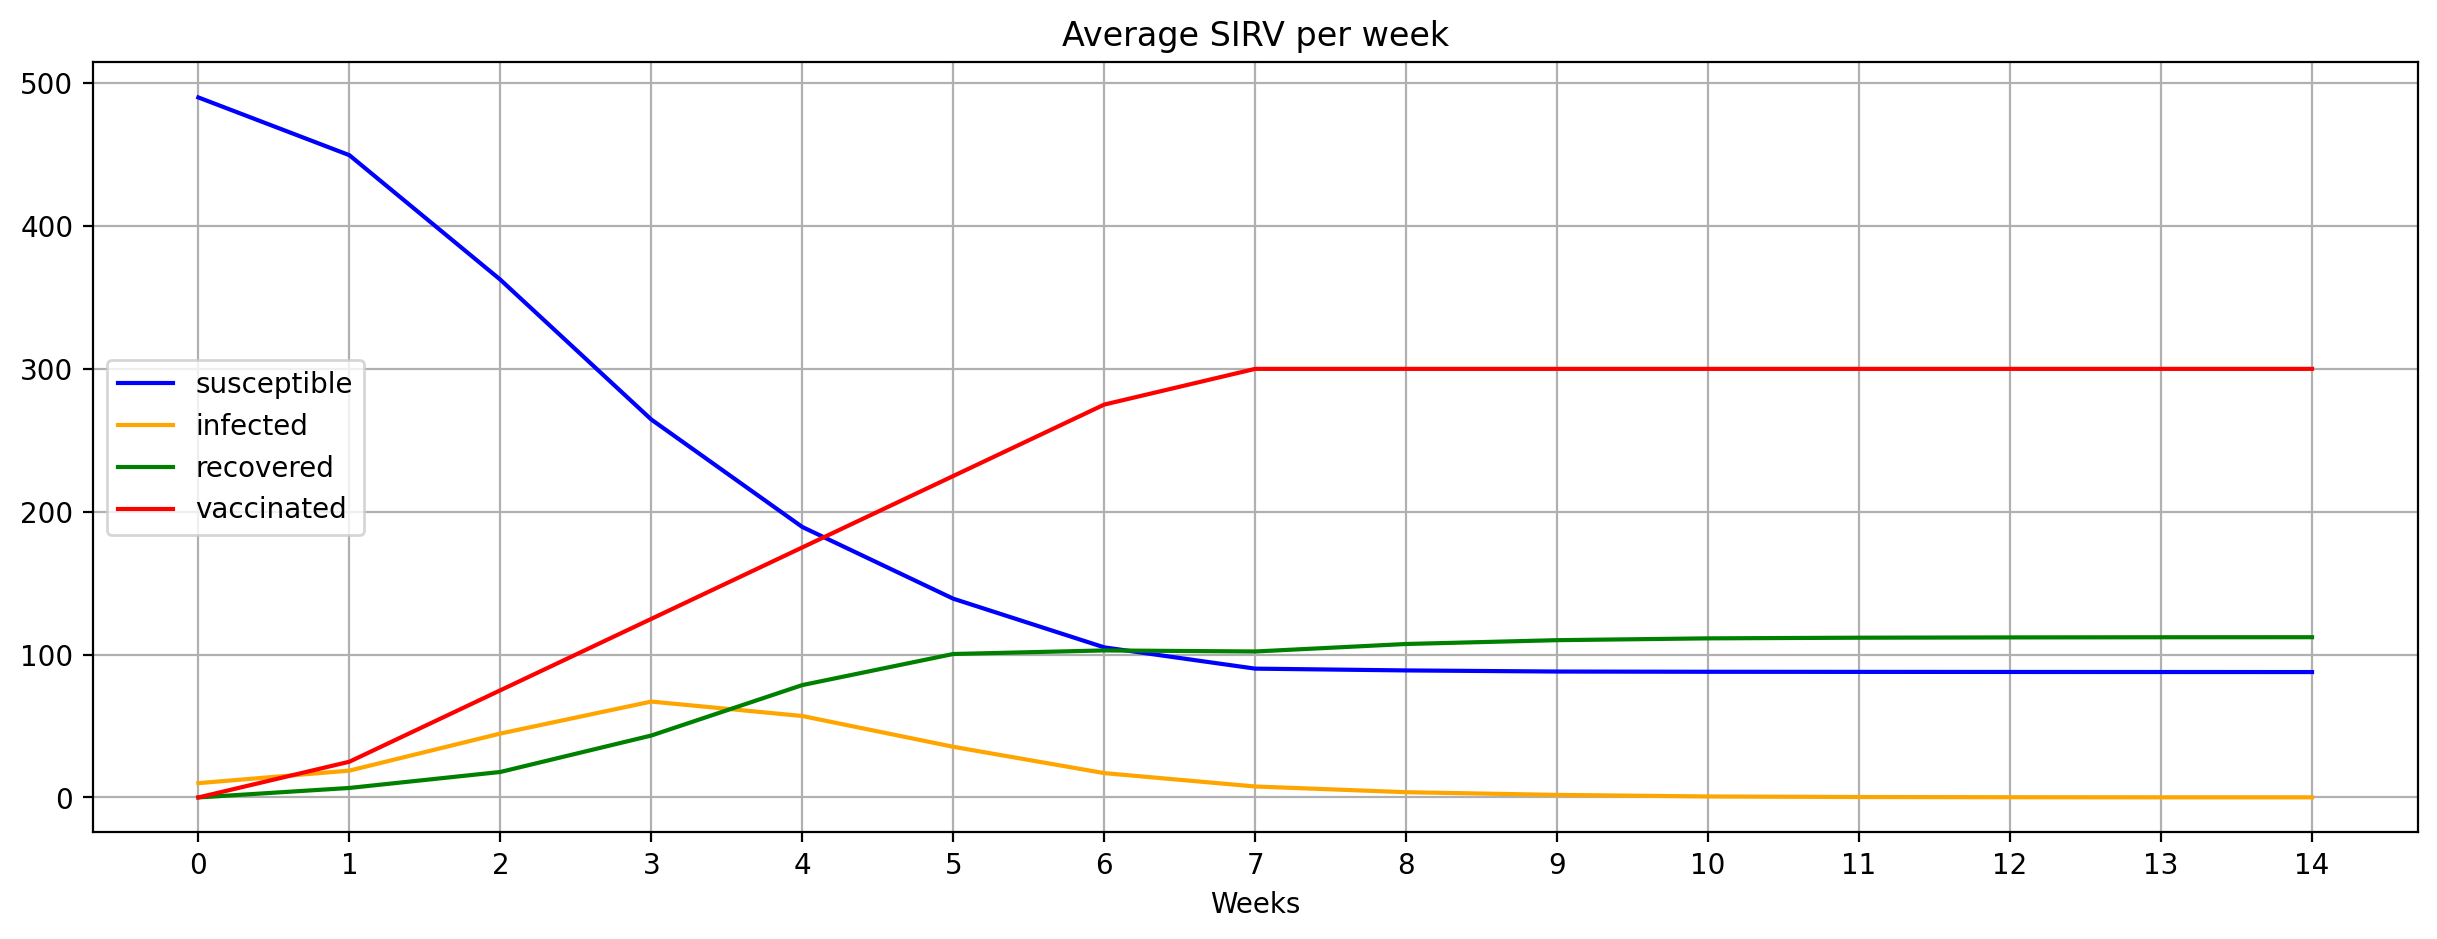

In [390]:
susc = np.mean(stat_i3, axis=0)[:,0]
inf = np.mean(stat_i3, axis=0)[:,1]
rec = np.mean(stat_i3, axis=0)[:,2]
vac = np.mean(stat_i3, axis=0)[:,3]
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
fs = sn.lineplot(data=list(susc), color='blue', label=S)
fi = sn.lineplot(data=list(inf), color='orange', label=I)
fr = sn.lineplot(data=list(rec), color='green', label=R)
fv = sn.lineplot(data=list(vac), color='red', label=V)
setx = fs.set_xticks(range(len(avg)))
sety = f.set_yticks(range(round(np.max(avg))+1))
setxlab = fs.set_xlabel('Weeks')
cap = fs.set_title('Average SIRV per week')
plt.legend(loc='center left')
plt.savefig('img/Vaccination_over_week.png')
plt.show()

## The H1N1 pandemic in Sweden 2009

***The H1N1 pandemic in Sweden 2009:*** *find the best parameters*

In [391]:
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
I0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

In [392]:
k0 = 10
beta0 = 0.3
rho0 = 0.6
nodes =  934
init_infected = 1
weeks = 16
N = 10
dbeta = 0.1
drho = 0.1
dk = 1

In [393]:
def run_experiments(params, nodes, N, init_infected, niter, vac, model_type):
    #np.random.seed(0)
    beta, rho, k = params
    stat_nw_infected = []
    for _ in range(N):
        G = model_type(nodes, int(k))
        s,nw_inf, _ = simulation(G, beta, rho, init_infected, niter, vac)
        stat_nw_infected.append(nw_inf)
    avg = np.mean(np.array(stat_nw_infected), axis=0)
    return list(avg)



In [436]:
def test_parameters_HalfDelta(beta, rho, k, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, model_type):
    loss_list = []
    params0 = [beta, rho, k] #initial parameter
    delta_params = [dbeta, drho, dk]
    best_l_p = []
    list_I = []
    list_best_loss = []

    while True:

        params = [[x-d, x, x+d] for x,d in zip(params0, delta_params)] #[(beta - delta, rho - delta, k - delta), (beta, rho, k), (beta + delta, rho + delta, k + delta)] 

        

        p = list(itertools.product(*params)) #all possible combination

        for i in range(len(p)):
            I1 = run_experiments(p[i], nodes, N, init_infected=init_infected, niter = weeks, vac = vacc, model_type = model_type)
            loss_list.append(np.sqrt(np.mean(np.square(np.array(I0)-np.array(I1)))))
            list_I.append(I1)


        best_params = list(p[np.argmin(loss_list)])
        best_params[0] = min(1, max(0, best_params[0]))
        best_params[1] = min(1, max(0, best_params[1]))
        print(f"loss: {np.min(loss_list)}, params: {best_params}, delta: {delta_params[0]}")

        l = np.min(loss_list)
        list_best_loss.append(l)

        bestI = list_I[np.argmin(loss_list)]
        best_l_p.append([l, best_params, bestI])

        loss_list = []
        list_I = []
        
        # check if current loss is better than the previous best loss
        if l > min(list_best_loss):
            delta_params = [d/2 for d in delta_params] # decrease delta_params by half

        if np.isclose(np.array(params0), np.array(best_params)).all() or delta_params[0]<0.0001:
            break
        
        params0 = best_params

    return best_l_p




In [ ]:
best_lp_preferential_half = test_parameters_HalfDelta(beta0, rho0, k0, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, preferential_attachment_random_graph)

loss: 4.029112805568988, params: [0.19999999999999998, 0.6, 10], delta: 0.1
loss: 8.897787646375923, params: [0.19999999999999998, 0.7, 10], delta: 0.1
loss: 5.7909951649090505, params: [0.14999999999999997, 0.6499999999999999, 10], delta: 0.05
loss: 5.73775870876425, params: [0.17499999999999996, 0.6749999999999999, 10], delta: 0.025
loss: 4.243524478543749, params: [0.18749999999999997, 0.6625, 10.125], delta: 0.0125
loss: 4.061557582996946, params: [0.18124999999999997, 0.6625, 10.0625], delta: 0.00625
loss: 4.154064274899945, params: [0.18437499999999996, 0.6593749999999999, 10.0625], delta: 0.003125
loss: 4.664024549678099, params: [0.18593749999999995, 0.6593749999999999, 10.078125], delta: 0.0015625
loss: 5.303477632648224, params: [0.18671874999999996, 0.65859375, 10.078125], delta: 0.00078125
loss: 4.723412431706552, params: [0.18710937499999997, 0.658203125, 10.078125], delta: 0.000390625
loss: 5.029972663941624, params: [0.18710937499999997, 0.658203125, 10.076171875], delta

In [ ]:
best_loss = np.argmin([p[0] for p in best_lp_preferential_half])
preferentialI = best_lp_preferential_half[best_loss][2]

In [ ]:
best_lp_small_half = test_parameters_HalfDelta(beta0, rho0, k0, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, small_world)

loss: 8.074225969094499, params: [0.4, 0.7, 11], delta: 0.1
loss: 7.725687671657456, params: [0.4, 0.7999999999999999, 11], delta: 0.1
loss: 6.87377261771147, params: [0.4, 0.8999999999999999, 11], delta: 0.1
loss: 6.842605497907943, params: [0.4, 0.8999999999999999, 11], delta: 0.1


In [ ]:
best_loss = np.argmin([p[0] for p in best_lp_small_half])
small_worldI = best_lp_small_half[best_loss][2]

In [ ]:
best_lp_conf_half = test_parameters_HalfDelta(beta0, rho0, k0, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, configuration_model)

loss: 8.140792344729105, params: [0.19999999999999998, 0.7, 11], delta: 0.1
loss: 7.226902863606235, params: [0.19999999999999998, 0.7999999999999999, 12], delta: 0.1
loss: 6.514598989960932, params: [0.19999999999999998, 0.7999999999999999, 12], delta: 0.1


In [ ]:
best_loss = np.argmin([p[0] for p in best_lp_conf_half])
configurationI = best_lp_conf_half[best_loss][2]

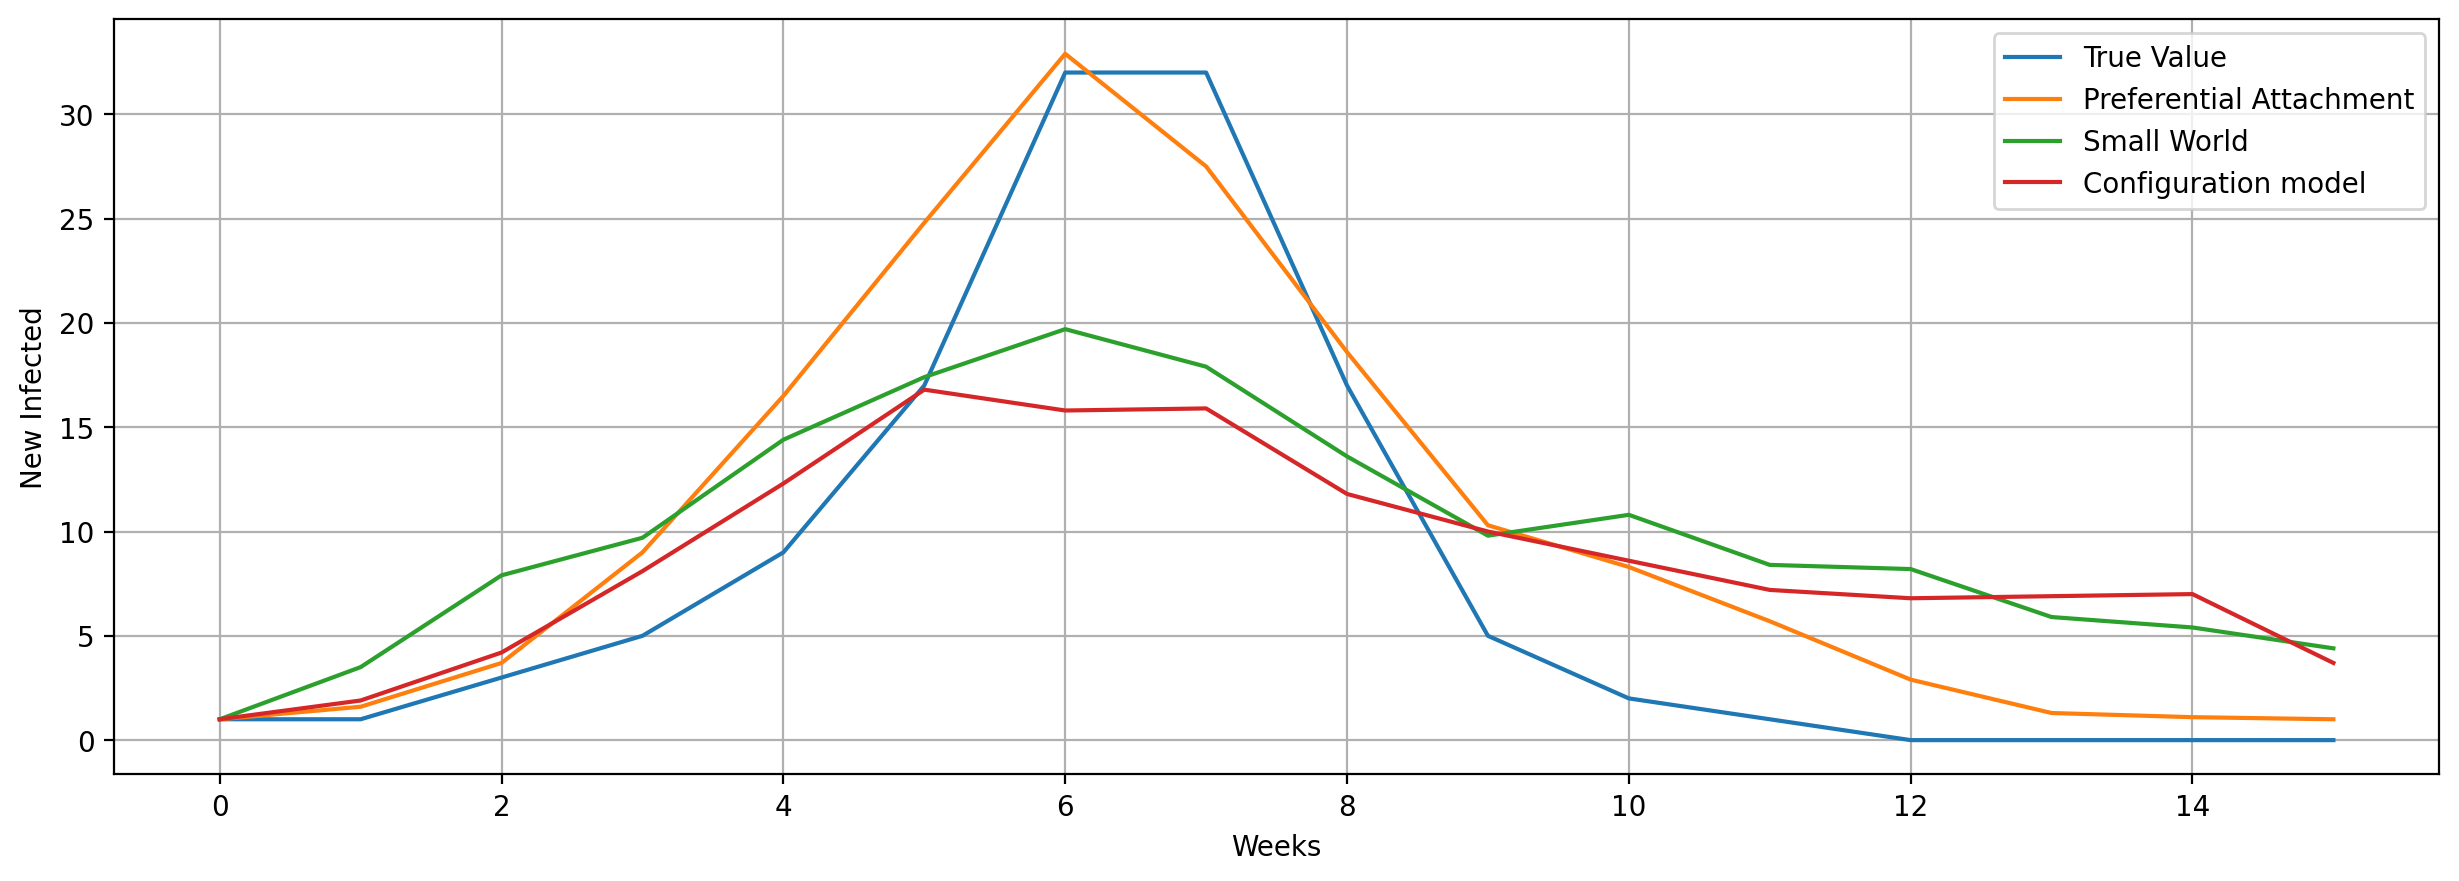

In [ ]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(x = list(range(16)), y = I0, label = "True Value")
f1 = sn.lineplot(x = list(range(16)), y = preferentialI, label = "Preferential Attachment")
f2 = sn.lineplot(x = list(range(16)), y = small_worldI, label = "Small World")
f2 = sn.lineplot(x = list(range(16)), y = configurationI, label = "Configuration model")
f.set_xlabel('Weeks')
f.set_ylabel('New Infected')
plt.savefig("New_inf_fit")

best parameters = (0.2, 0.6, 10)

### Running simulations of H1N1 with best parameters

Parameters from Preferential Attachment model

In [396]:
k = 10
beta = 0.2
rho = 0.6
nodes =  934
init_infected = 1
weeks = 16
N = 10
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
stat_i4 = []
weekly_inf4 = []
for _ in range(100):
    G = preferential_attachment_random_graph(nodes, k)
    stat, inf, vaccinated = simulation(G, beta, rho, n_infected, weeks, vacc)

    stat_i4.append(stat)
    weekly_inf4.append(inf)

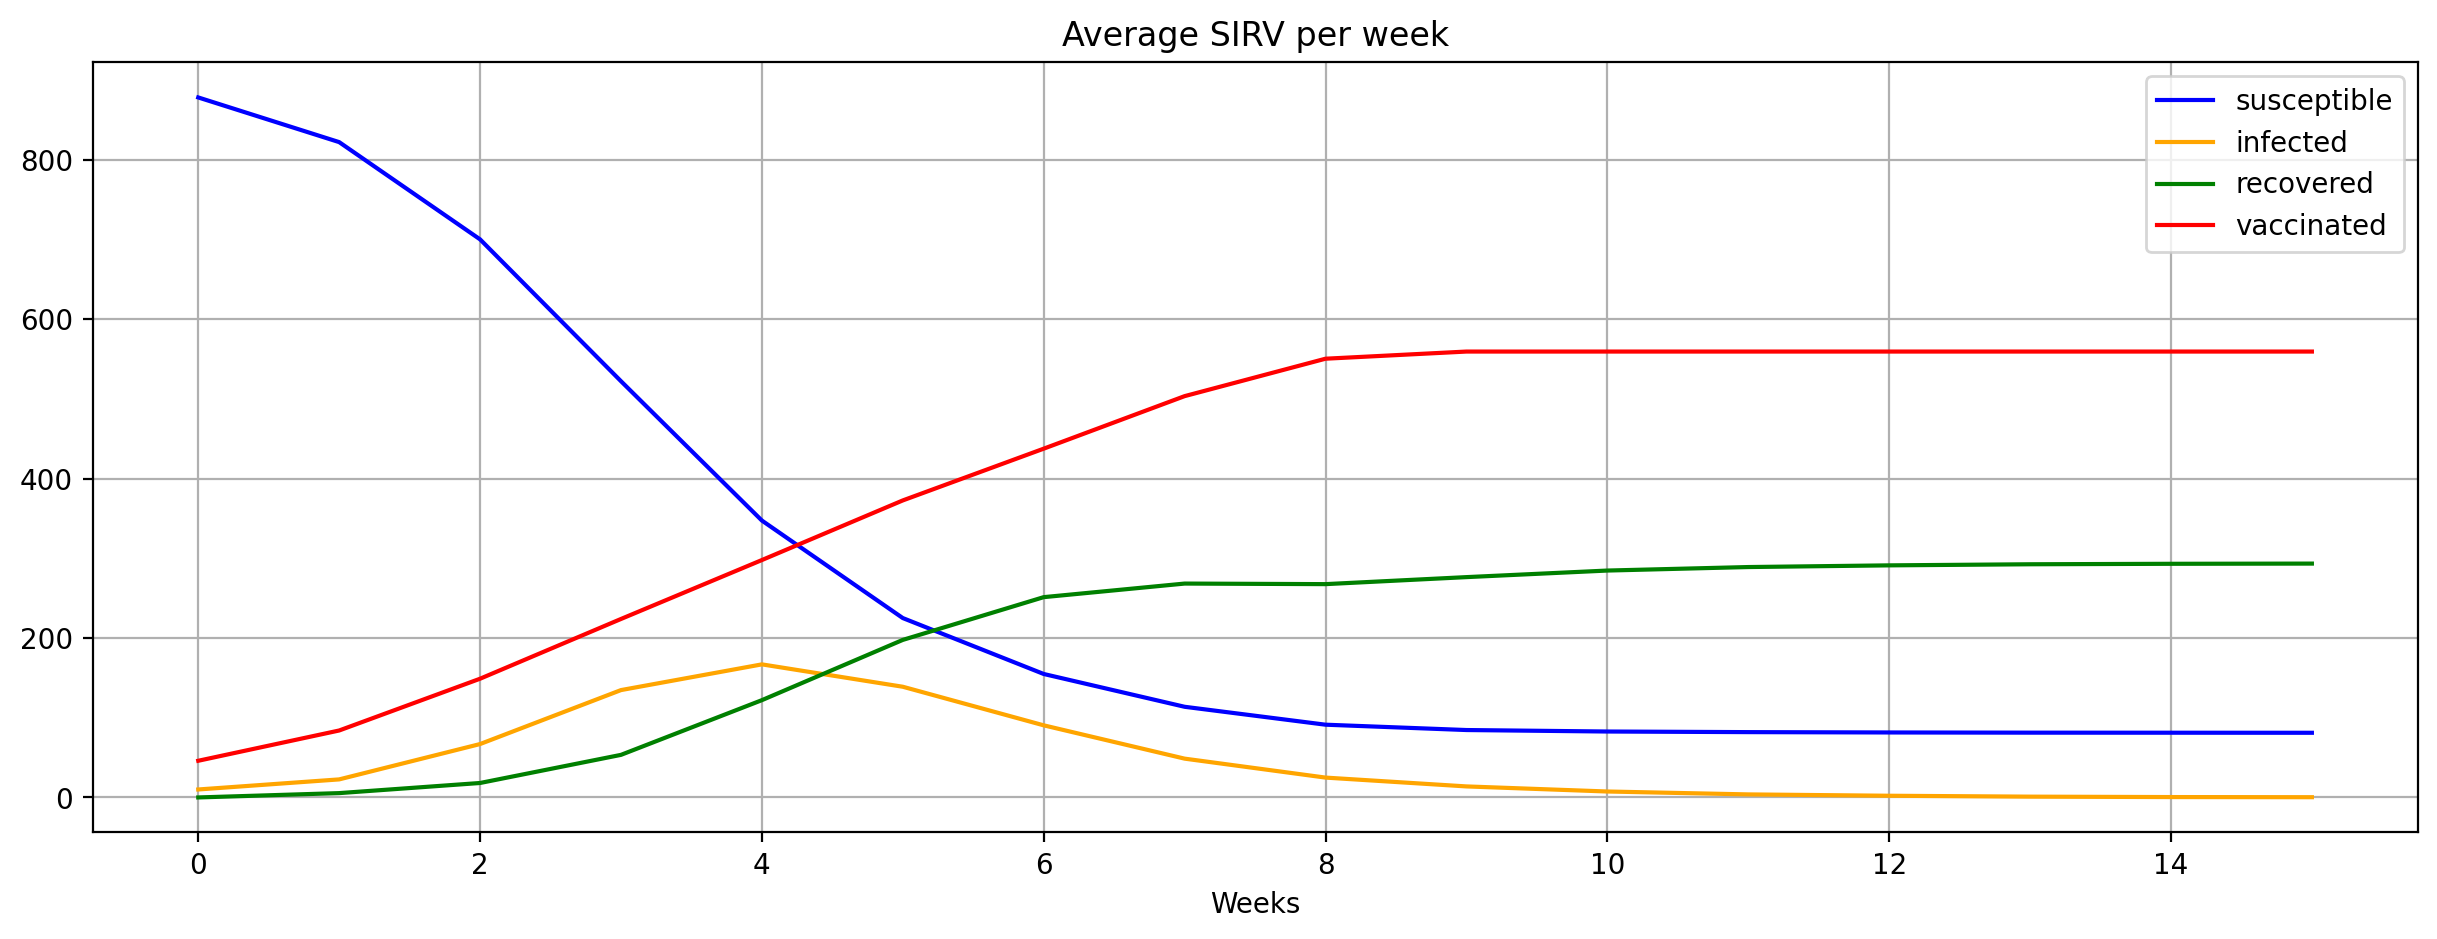

In [397]:
susc = np.mean(stat_i4, axis=0)[:,0]
inf = np.mean(stat_i4, axis=0)[:,1]
rec = np.mean(stat_i4, axis=0)[:,2]
vac = np.mean(stat_i4, axis=0)[:,3]
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
fs = sn.lineplot(data=list(susc), color='blue', label=S)
fi = sn.lineplot(data=list(inf), color='orange', label=I)
fr = sn.lineplot(data=list(rec), color='green', label=R)
fv = sn.lineplot(data=list(vac), color='red', label=V)
#setx = fs.set_xticks(range(len(avg)))
#sety = f.set_yticks(range(round(np.max(avg))+1))
setxlab = fs.set_xlabel('Weeks')
cap = fs.set_title('Average SIRV per week')
plt.legend(loc='upper right')
plt.savefig('img/SIRV_best_params.png')
#plt.show()

## Challenge

In [ ]:
def test_parameters_decay_rate(beta, rho, k, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, model_type, decay_rate):
    loss_list = []
    params0 = [beta, rho, k] #initial parameter
    delta_params = [dbeta, drho, dk]
    best_l_p = []
    list_I = []
    iteration = 0

    while True:

        # Apply polynomial decay to delta values
        delta_params = [d * (1 - decay_rate) ** iteration for d in delta_params]
        
        params = [[x-d, x, x+d] for x,d in zip(params0, delta_params)] #[(beta - delta, rho - delta, k - delta), (beta, rho, k), (beta + delta, rho + delta, k + delta)] 

        p = list(itertools.product(*params)) #all possible combination

        for i in range(len(p)):
            I1 = run_experiments(p[i], nodes, N, init_infected=init_infected, niter = weeks, vac = vacc, model_type = model_type)
            loss_list.append(np.sqrt(np.mean(np.square(np.array(I0)-np.array(I1)))))
            list_I.append(I1)

        

        best_params = list(p[np.argmin(loss_list)])
        best_params[0] = min(1, max(0, best_params[0]))
        best_params[1] = min(1, max(0, best_params[1]))
        print(f"loss: {np.min(loss_list)}, params: {best_params}")
        l = np.min(loss_list)
        bestI = list_I[np.argmin(loss_list)]
        best_l_p.append([l, best_params, bestI])
        loss_list = []
        list_I = []
        iteration += 1
        


        if np.isclose(np.array(params0), np.array(best_params)).all():
            break
        
        params0 = best_params
        

    return best_l_p


In [ ]:
best_lp_preferential_decay = test_parameters_decay_rate(beta0, rho0, k0, dbeta, drho, dk, I0, vacc, init_infected, nodes, weeks, preferential_attachment_random_graph, 0.2)

loss: 9.808159868191384, params: [0.19999999999999998, 0.6, 10]
loss: 5.938276265045269, params: [0.19999999999999998, 0.6799999999999999, 10]
loss: 3.1553525951943944, params: [0.19999999999999998, 0.6287999999999999, 10.512]
loss: 4.495970418052147, params: [0.19999999999999998, 0.6550143999999999, 10.512]
loss: 4.228992196729618, params: [0.19999999999999998, 0.6550143999999999, 10.6193741824]
loss: 3.5063335551541583, params: [0.19648156279111678, 0.6514959627911167, 10.654558554488831]
loss: 4.27595018680059, params: [0.19648156279111678, 0.6514959627911167, 10.645335182451976]
loss: 5.3863252779608475, params: [0.19628813465997844, 0.6513025346599783, 10.645335182451976]
loss: 5.012546757886653, params: [0.19628813465997844, 0.6512700828046125, 10.645659701005634]
loss: 5.463400955448905, params: [0.19628813465997844, 0.651265727190316, 10.645659701005634]


In [ ]:
best_loss = np.argmin([p[0] for p in best_lp_preferential_decay])
preferentialI = best_lp_preferential_decay[best_loss][2]

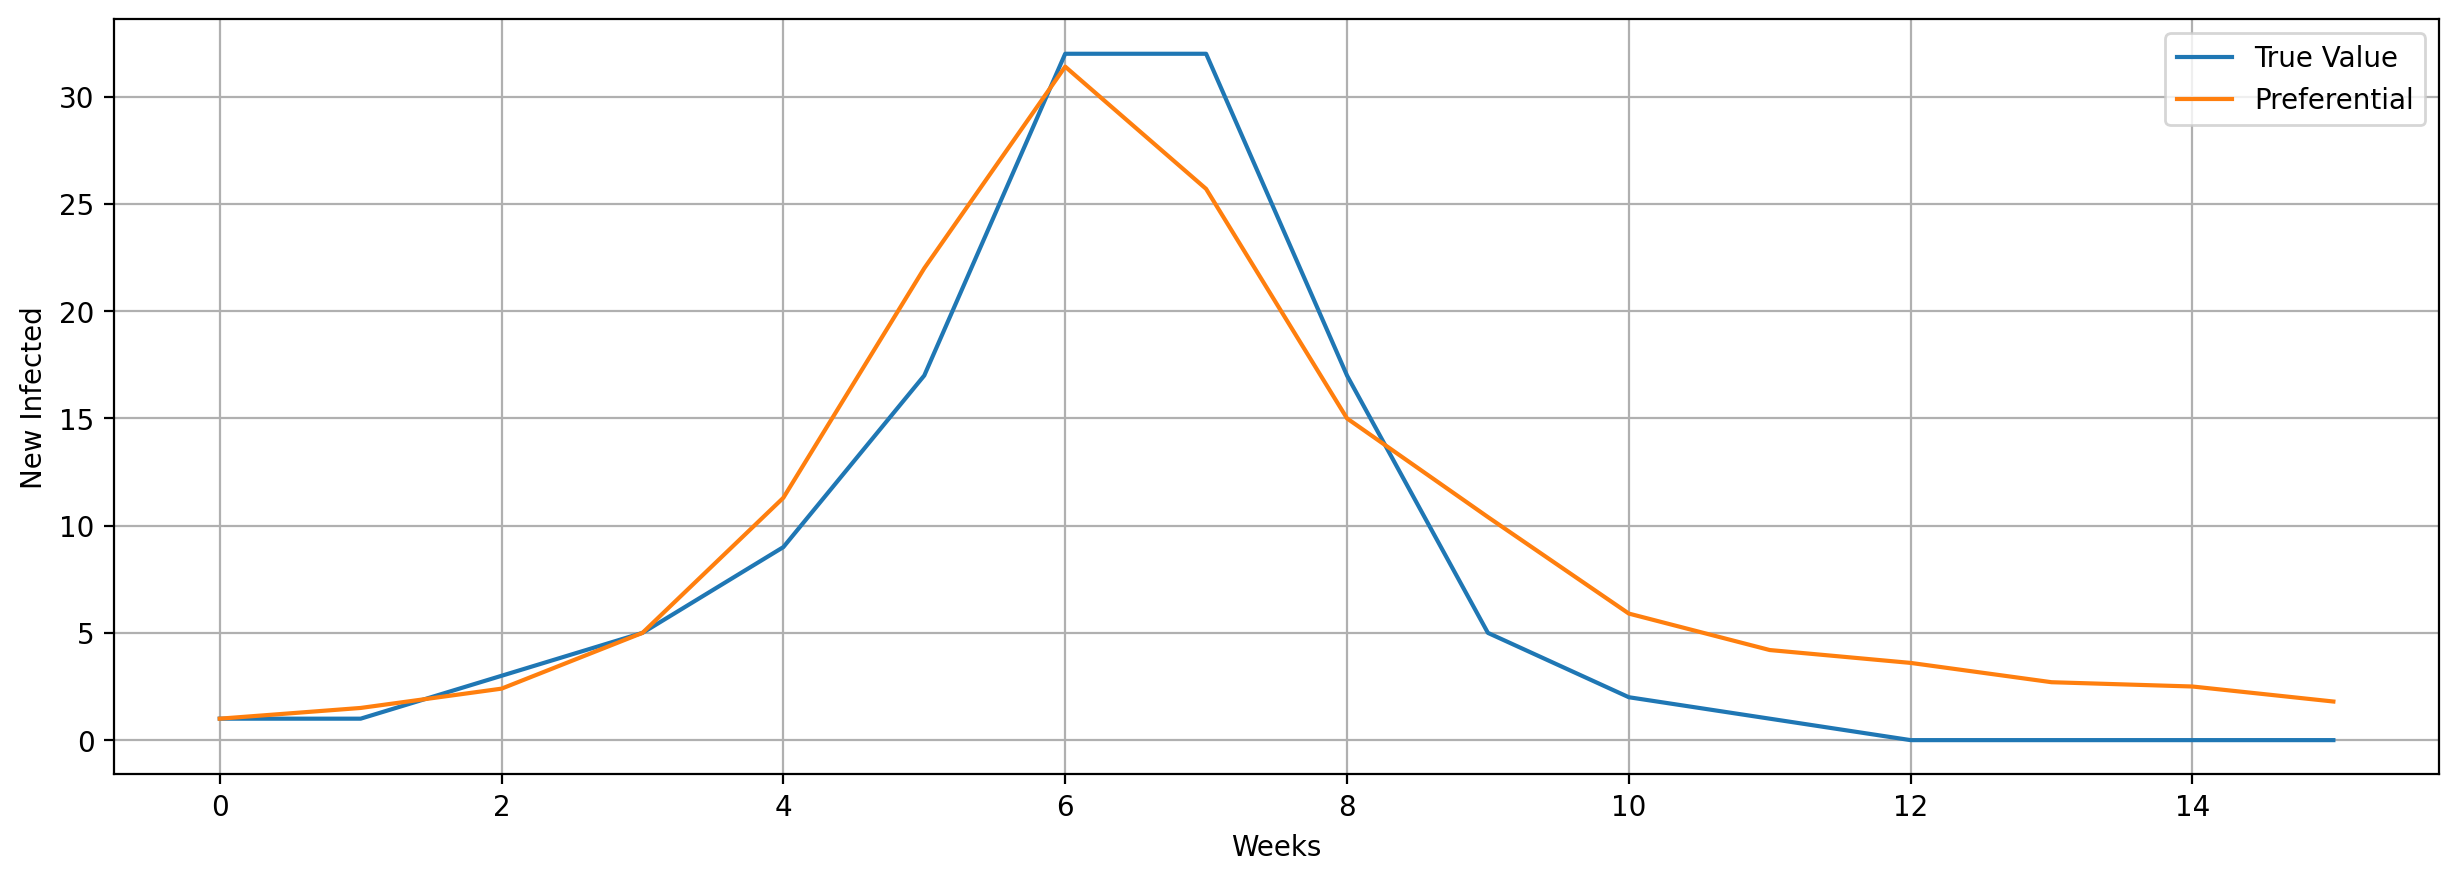

In [ ]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(x = list(range(16)), y = I0, label="True Value")
f1 = sn.lineplot(x = list(range(16)), y = preferentialI, label = "Preferential")
f.set_xlabel('Weeks')
f.set_ylabel('New Infected')
plt.savefig("New_inf_fit_decay")

# Coloring

In [398]:
import networkx as nx
import numpy as np
import seaborn as  sn
from math import e
import itertools
from matplotlib import pyplot as plt

### Functions

In [400]:
def cost(status, status_neigh, possible_stat):
    return np.array(status == status_neigh, dtype=int)

def noisy(t):
    return t/100

def status_n(node, W, dict_s):  #state of neighbours
    idx = np.where(W[node, :]>0)[0]
    return np.array([dict_s[n] for n in idx])

def weight_neigh(node, W): #wheight of neighbours
    return W[node, :][W[node, :]>0]

def k_line(n):
    G = nx.Graph()
    G.add_edges_from([(i,i+1) for i in range(0,n-1)])
    return G

def inizialize_status(nodes, status):
    return {n:status for n in range(nodes)}

def potential(dict_s, W, cost_f, possible_stat):
    return 0.5*sum([sum(weight_neigh(node, W)*cost_f(dict_s[node], status_n(node, W, dict_s), possible_stat)) for node in nodes])

def cases_function(node, status, dict_s, W, t, cost_f, possible_stat):
    return np.power(e,((-noisy(t))*sum(weight_neigh(node, W)*cost_f(status, status_n(node, W, dict_s), possible_stat))))

def P(status, possible_stat, node, W, t, dict_s, cost_f):
    #print(f"node: {node}\nstatus: {status}\ndicts: {dict_s}\nW: {W}\nt: {t}")
    favour_case = cases_function(node, status, dict_s, W, t, cost_f, possible_stat)
    possible_cases = sum([cases_function(node, s, dict_s, W, t, cost_f, possible_stat) for s in possible_stat])
    return favour_case/possible_cases
    
def cost_wifi(status, status_neigh, possible_stat):
    dict_stat = dict(zip(possible_stat, range(len(possible_stat))))
    idx_s = np.array(dict_stat[status])
    idx_s_neigh = np.array([dict_stat[s] for s in status_neigh])
    c = np.abs(idx_s_neigh - idx_s)
    m1 = c==0
    m2 = c==1
    m3 = c> 1
    c[m1] = 2
    c[m2] = 1
    c[m3] = 0
    return c

## Line graph

***Line graph: applying coloring***

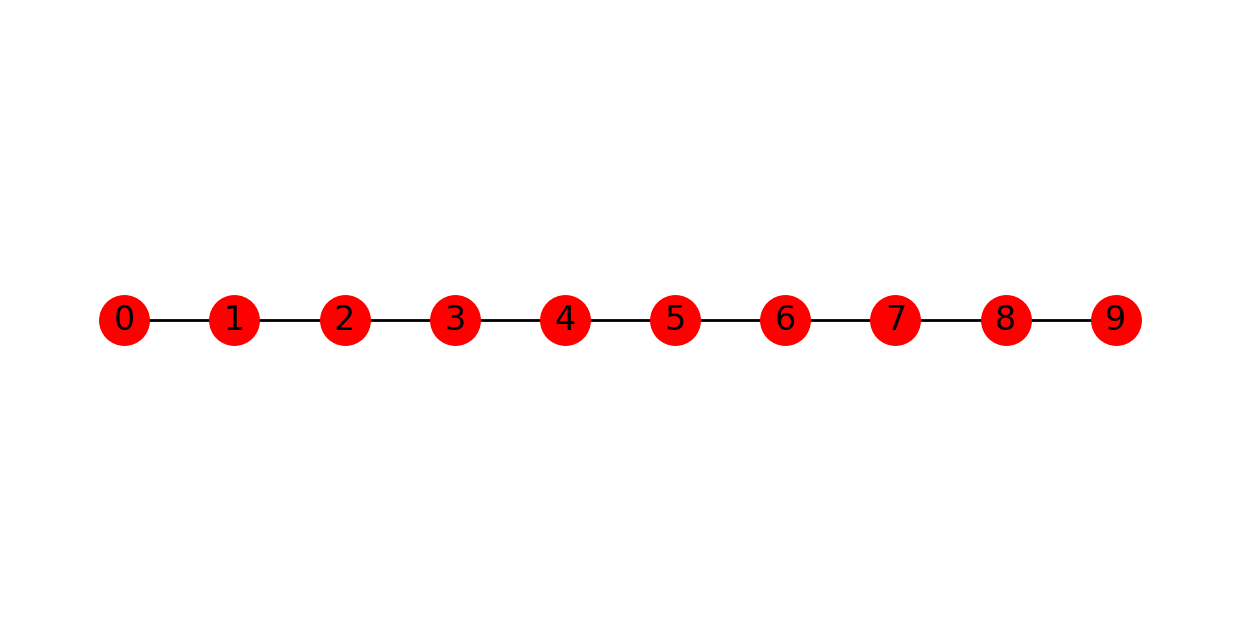

In [432]:
G = k_line(10)
pos = {0: [0,0], 1: [1,0], 2: [2,0], 3: [3,0], 4: [4,0], 5: [5,0], 6: [6,0], 7: [7,0], 8: [8,0], 9: [9,0] }
plt.figure(dpi=200, figsize=(6,3))
nx.draw(G, pos=pos, node_color='r', with_labels=True)
#plt.savefig('img/line_graph.png')

In [433]:
nx.is_bipartite(G)

True

In [ ]:
W = nx.to_numpy_array(G)
d = inizialize_status(len(W), "red")
possible_stat = ['red', 'green']
nodes = list(range(len(W)))

t = 0
p = []

print(f"initial state: {d}")

while potential(d, W, cost, possible_stat) != 0:
    p.append(potential(d, W, cost, possible_stat))
    n = np.random.choice(nodes)
    dist = [P(s, possible_stat, n, W, t, d, cost) for s in possible_stat]
    next_stat = np.random.choice(possible_stat, p = dist)
    d[n] = next_stat
    t+= 1
t+= 1
p.append(potential(d, W, cost, possible_stat))
print(f"final state: {d}")

In [ ]:
plt.figure(dpi=200, figsize=(6,3))
nx.draw(G, pos=pos, node_color = d.values(), with_labels=True)
plt.savefig('img/line_after.png')

In [ ]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(x = list(range(t)), y = p)
f.set_xlabel('Time')
f.set_ylabel('Potential function')
plt.savefig('img/line_potential.png')

## Wifi-channels assignment

***Wifi coloring***

In [402]:
W = np.loadtxt('wifi.mat')

possible_stat = [ "red", "green", "blue", "orange", "magenta", "cyan", "grey", "black"]
nodes = list(range(len(W)))
tmax = 1000

prob = []
for _ in range(3):
    #noisy = func[i]
    d = inizialize_status(len(W), "red")
    print(f"initial state: {d}")
    d_list  = []
    d_list.append(d.copy())
    t = 0
    p = []
    while potential(d, W, cost_wifi, possible_stat) != 0 and t<tmax:
        p.append(potential(d, W, cost_wifi, possible_stat))
        n = np.random.choice(nodes)
        dist = [P(s, possible_stat, n, W, t, d, cost_wifi) for s in possible_stat]
        next_stat = np.random.choice(possible_stat, p = dist)
        d[n] = next_stat
        d_list.append(d.copy())
        t+= 1
    t+= 1
    p.append(potential(d, W, cost_wifi, possible_stat))
    prob.append(p)
print(f"final state: {d}")

initial state: {0: 'red', 1: 'red', 2: 'red', 3: 'red', 4: 'red', 5: 'red', 6: 'red', 7: 'red', 8: 'red', 9: 'red', 10: 'red', 11: 'red', 12: 'red', 13: 'red', 14: 'red', 15: 'red', 16: 'red', 17: 'red', 18: 'red', 19: 'red', 20: 'red', 21: 'red', 22: 'red', 23: 'red', 24: 'red', 25: 'red', 26: 'red', 27: 'red', 28: 'red', 29: 'red', 30: 'red', 31: 'red', 32: 'red', 33: 'red', 34: 'red', 35: 'red', 36: 'red', 37: 'red', 38: 'red', 39: 'red', 40: 'red', 41: 'red', 42: 'red', 43: 'red', 44: 'red', 45: 'red', 46: 'red', 47: 'red', 48: 'red', 49: 'red', 50: 'red', 51: 'red', 52: 'red', 53: 'red', 54: 'red', 55: 'red', 56: 'red', 57: 'red', 58: 'red', 59: 'red', 60: 'red', 61: 'red', 62: 'red', 63: 'red', 64: 'red', 65: 'red', 66: 'red', 67: 'red', 68: 'red', 69: 'red', 70: 'red', 71: 'red', 72: 'red', 73: 'red', 74: 'red', 75: 'red', 76: 'red', 77: 'red', 78: 'red', 79: 'red', 80: 'red', 81: 'red', 82: 'red', 83: 'red', 84: 'red', 85: 'red', 86: 'red', 87: 'red', 88: 'red', 89: 'red', 90: 

In [ ]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(x = list(range(t)), y = prob[0], label='simulation 1')
f = sn.lineplot(x = list(range(t)), y = prob[1], label='simulation 2')
f = sn.lineplot(x = list(range(t)), y = prob[2], label='simulation 3')
f.set_xlabel('Time')
f.set_ylabel('Potential function')
plt.savefig('img/Three_exp_potential_wifi.png')

In [ ]:
G2 = nx.from_numpy_matrix(W)
cord = np.loadtxt('coords.mat')
plt.figure(dpi = 200, figsize=(5,5))
nx.draw(G2, pos = cord, node_color = 'red', node_size=30, with_labels=False)
plt.savefig('img/color_map_wifi_allred.png')

In [ ]:
plt.figure(dpi = 200, figsize=(5,5))
nx.draw(G2, pos = cord, node_color = d_list[-1].values(), node_size=30, with_labels=False)
plt.savefig('img/color_map_wifi.png')

## Optional

***Optional***

In [429]:
def noisy_unitary(t):
    return 1

def noisy_log(t):
    return np.log(t+1)

def noisy_small(t):
    return 0.01

In [430]:
W = np.loadtxt('wifi.mat')

possible_stat = [ "red", "green", "blue", "orange", "magenta", "cyan", "grey", "black"]
nodes = list(range(len(W)))
tmax = 1000

prob = []
func = [noisy_unitary, noisy_small, noisy_log]
#print(f"initial state: {d}")
for i in range(3):
    noisy = func[i]
    d = inizialize_status(len(W), "red")
    d_list  = []
    d_list.append(d.copy())
    t = 0
    p = []
    while potential(d, W, cost_wifi, possible_stat) != 0 and t<tmax:
        p.append(potential(d, W, cost_wifi, possible_stat))
        n = np.random.choice(nodes)
        dist = [P(s, possible_stat, n, W, t, d, cost_wifi) for s in possible_stat]
        next_stat = np.random.choice(possible_stat, p = dist)
        d[n] = next_stat
        d_list.append(d.copy())
        t+= 1
    t+= 1
    p.append(potential(d, W, cost_wifi, possible_stat))
    prob.append(p)
#print(f"final state: {d}")

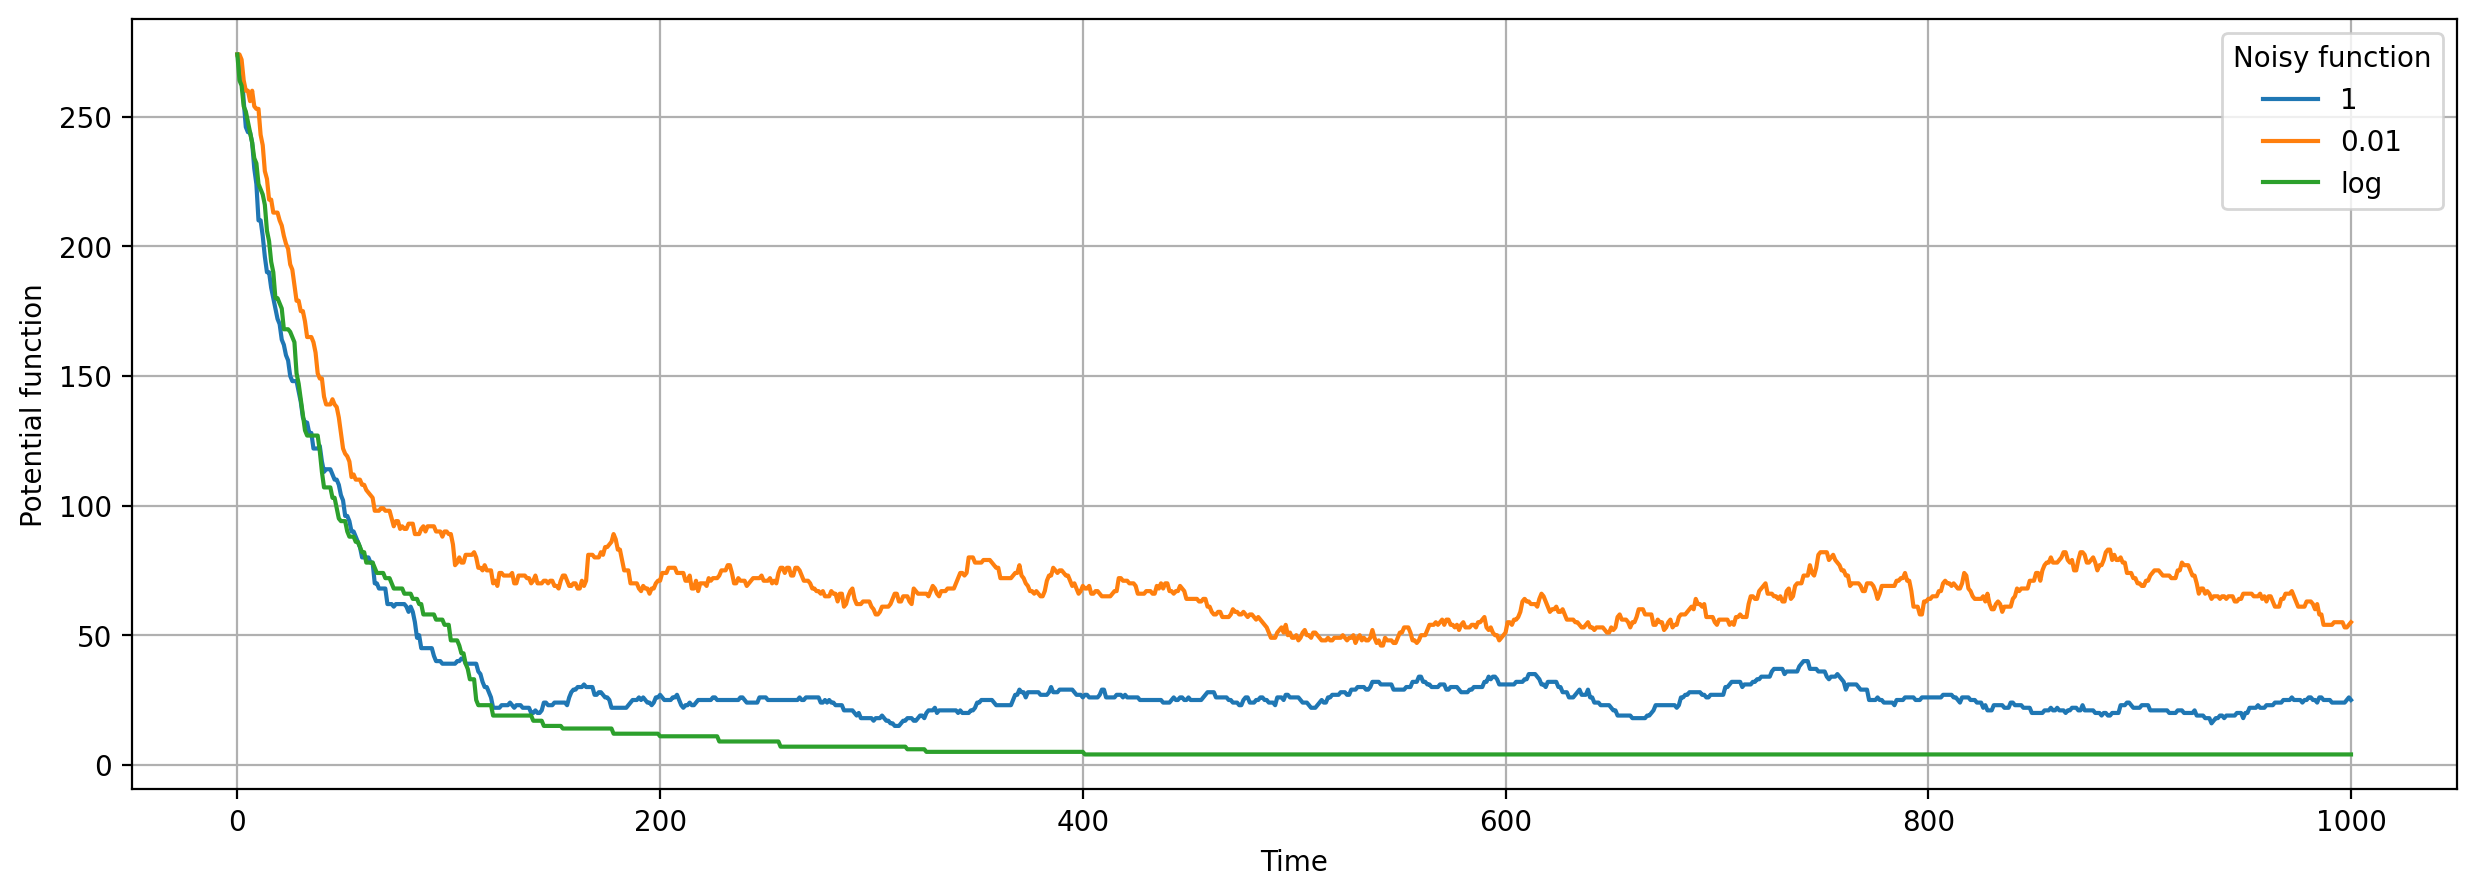

In [431]:
plt.figure(dpi = 200, figsize=(15,5))
plt.grid()
f = sn.lineplot(x = list(range(t)), y = prob[0], label='1')
f = sn.lineplot(x = list(range(t)), y = prob[1], label='0.01')
f = sn.lineplot(x = list(range(t)), y = prob[2], label='log')
f.set_xlabel('Time')
f.set_ylabel('Potential function')
plt.legend(title='Noisy function')
plt.savefig('img/noisy_function.png')